<a href="https://colab.research.google.com/github/ymkge/stock_price_analysis/blob/main/%E6%A0%AA%E5%BC%8F%E5%89%B2%E5%AE%89%E9%8A%98%E6%9F%84%E5%8F%96%E5%BE%97%E3%83%87%E3%83%BC%E3%82%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install yahooquery

In [5]:
# データフレームのライブラリを読み込む
import pandas as pd

# yahooqueryのライブラリを読み込む
from yahooquery import Ticker

# 銘柄を抽出する際の条件
dividendYield_donw_limit = 0.03     # 配当利回り下限
dividendYield_upper_limit = 0.06    # 配当利回り上限
payoutratio = 0.5                   # 配当性向
marketcap = 100000000000            # 時価総額
roe = 0.08                           # 自己資本利益率
capitalAdequacyRatio = 0.3          # 自己資本比率
dividends_period = '10y'            # 配当増減のチェック期間

# メイン処理
# 引数:無し
# 戻値:無し
def main():
    # 当期の企業指標のCSVファイルを読み込む
    df_company_metrics = pd.read_csv('./company_metrics.csv', encoding='cp932')

    # 配当利回り、配当性向、時価総額、自己資本利益率が条件を満たしている銘柄を抽出する
    find_dividendYield = df_company_metrics[df_company_metrics['dividendYield'] >= dividendYield_donw_limit]
    find_dividendYield = find_dividendYield[find_dividendYield['dividendYield'] <= dividendYield_upper_limit]
    # ▼▼▼▼▼ エラー箇所を修正 ▼▼▼▼▼
    find_payoutratio = find_dividendYield[find_dividendYield['payoutRatio'] <= payoutratio]
    find_marketcap = find_payoutratio[find_payoutratio['MarketCap'] >= marketcap]
    # ▲▲▲▲▲ エラー箇所を修正 ▲▲▲▲▲
    find_roe = find_marketcap[find_marketcap['ROE'] >= roe]

    # 配当利回り、配当性向、時価総額、自己資本利益率の条件を満たしている銘柄の証券コードを取得する
    ticker_list_conditional_match = list(find_roe['ticker'])

    # 過去の企業財務のCSVファイルを読み込む
    df_company_financial_info = pd.read_csv('./company_financial_info.csv', encoding='cp932')

    # 自己資本比率、売上高、純利益、配当履歴が高配当の条件を満たしているかを確認する
    ticker_list = []
    for ticker in ticker_list_conditional_match:
        continue_flag = 0
        selected_ticker = df_company_financial_info[df_company_financial_info['symbol'] == ticker]

        # 自己資本比率がしきい値を満たしているかを判定する
        is_cleared = selected_ticker['capitalAdequacyRatio'] >= capitalAdequacyRatio

        if False in is_cleared.values:
            print(ticker + 'は自己資本比率が' + str(capitalAdequacyRatio) + 'を満たしていない')
            continue

        # 売上高、純利益の増減を確認する
        # 両方とも増減している場合は除外する
        check_list = ['TotalRevenue', 'StockholdersEquity']

        for check in check_list:
            is_increasing = selected_ticker[check].diff().fillna(0) >= 0
            if False in is_increasing.values:
                print(ticker + 'は' + check + 'が増減している')
                continue_flag += 1

        if continue_flag == 2:
            continue

        # 過去10年の配当履歴の増減を確認する
        ticker_data = Ticker(ticker)
        ticker_data_history = ticker_data.history(period=dividends_period, interval='1mo')
        ticker_data_history_dividends = ticker_data_history['dividends']
        ticker_data_history_dividends = ticker_data_history.query('dividends != 0')

        is_increasing = ticker_data_history_dividends['dividends'].diff().fillna(0) >= 0
        if False in is_increasing.values:
            print(ticker + 'は' + '減配している')
            continue

        ticker_list.append(ticker)

    # 条件を満たした銘柄を保存する
    company_match_condition = pd.DataFrame()
    for ticker in ticker_list:
        match = df_company_metrics['ticker'].str.contains(ticker)
        company_match_condition = pd.concat([company_match_condition, df_company_metrics[match]])

    company_match_condition.to_csv('./company_match_condition.csv', encoding='cp932', index=False)


if __name__ == "__main__":
    main()

FileNotFoundError: [Errno 2] No such file or directory: './company_metrics.csv'

# JPX日本上場企業情報サービスから最新の銘柄情報を取得する

In [6]:
import requests
url = 'https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls' # ファイルのURLを指定する
filename = 'data_j.xlsx' # 保存するファイル名を指定する
response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)

In [7]:
import pandas as pd

# XLSXファイルを読み込み、DataFrameに変換
bond_master = pd.read_excel('data_j.xlsx')

bond_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4409 entries, 0 to 4408
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   日付       4409 non-null   int64 
 1   コード      4409 non-null   object
 2   銘柄名      4409 non-null   object
 3   市場・商品区分  4409 non-null   object
 4   33業種コード  4409 non-null   object
 5   33業種区分   4409 non-null   object
 6   17業種コード  4409 non-null   object
 7   17業種区分   4409 non-null   object
 8   規模コード    4409 non-null   object
 9   規模区分     4409 non-null   object
dtypes: int64(1), object(9)
memory usage: 344.6+ KB


In [8]:
bond_master[["コード", "銘柄名", "市場・商品区分", "33業種区分", "17業種区分"]].head()

,コード,銘柄名,市場・商品区分,33業種区分,17業種区分
0,1301,極洋,プライム（内国株式）,水産・農林業,食品
1,1305,ｉＦｒｅｅＥＴＦ ＴＯＰＩＸ（年１回決算型）,ETF・ETN,-,-
2,1306,ＮＥＸＴ ＦＵＮＤＳ ＴＯＰＩＸ連動型上場投信,ETF・ETN,-,-
3,1308,上場インデックスファンドＴＯＰＩＸ,ETF・ETN,-,-
4,1309,ＮＥＸＴ ＦＵＮＤＳ ＣｈｉｎａＡＭＣ・中国株式・上証５０連動型上場投信,ETF・ETN,-,-


In [9]:
## 銘柄コードを取得
# codes = bond_master["コード"].sample(n=500) ## テスト用に5件だけ取得する
codes = bond_master["コード"]
codes

,コード
0,1301
1,1305
2,1306
3,1308
4,1309
...,...
4404,9991
4405,9993
4406,9994
4407,9996


In [10]:
codes.describe

<bound method NDFrame.describe of 0       1301
1       1305
2       1306
3       1308
4       1309
        ... 
4404    9991
4405    9993
4406    9994
4407    9996
4408    9997
Name: コード, Length: 4409, dtype: object>

## 銘柄コードから各種分析用項目の取得

In [11]:
# ライブラリ読み込み
import yfinance as yf
from datetime import datetime, date, timedelta

# 本日を取得
today = datetime.today()

# 前日を取得（形式を'%Y-%m-%d'に変更）する
date = (today - timedelta(days=1)).strftime('%Y-%m-%d')

In [12]:
# 銘柄を抽出する際の条件
dividendYield_donw_limit = 0.03     # 配当利回り下限
dividendYield_upper_limit = 0.07    # 配当利回り上限
payoutratio = 0.3                  # 配当性向
marketcap = 50000000000       # 時価総額
roe = 0.08                         # 自己資本利益率
capitalAdequacyRatio = 0.3          # 自己資本比率
dividends_period = '10y'            # 配当増減のチェック期間

# 配当利回り、配当性向、時価総額、自己資本利益率が条件を満たしている銘柄を抽出する
# find_dividendYield = df_company_metrics[df_company_metrics['dividendYield'] >= dividendYield_donw_limit]
# find_dividendYield = find_dividendYield[find_dividendYield['dividendYield'] <= dividendYield_upper_limit]
# find_payoutratio = find_dividendYield[find_dividendYield['payoutRatio'] <= payoutratio] find_marketcap = find_payoutratio[find_payoutratio['MarketCap'] >= marketcap]
# find_roe = find_marketcap[find_marketcap['ROE'] >= roe]

# # 自己資本比率がしきい値を満たしているかを判定する
# is_cleared = selected_ticker['capitalAdequacyRatio'] >= capitalAdequacyRatio

# # 過去10年の配当履歴の増減を確認する
# ticker_data = Ticker(ticker)
# ticker_data_history = ticker_data.history(period=dividends_period, interval='1mo')
# ticker_data_history_dividends = ticker_data_history['dividends']
# ticker_data_history_dividends = ticker_data_history.query('dividends != 0')

# is_increasing = ticker_data_history_dividends['dividends'].diff().fillna(0) >= 0
# if False in is_increasing.values:
#     print(ticker + 'は' + '減配している')
#     continue

In [13]:
import yfinance as yf

# 株価データを取得
stock = yf.Ticker("8593.T")
data = stock.financials

# 自己資本比率を計算
net_income = data.loc["netIncomeToCommon"]
total_equity = data.loc["Total stockholders' equity"]
debt_to_equity_ratio = net_income / total_equity

print(debt_to_equity_ratio)

KeyError: 'netIncomeToCommon'

In [14]:
codes = [
    2003, # 日東富士製粉
    8766, # 東京海上ホールディングス
    1928, # 積水ハウス
    3003, # ヒューリック
    4502, # 武田薬品工業
    8306, # 三菱ＵＦＪフィナンシャル・グループ
    9433, # ＫＤＤＩ
    5334, # 日本特殊陶業
    8316, # 三井住友フィナンシャルグループ
    7995, # バルカー
    9432, # 日本電信電話
    3817, # ＳＲＡホールディングス
    8593, # 三菱ＨＣキャピタル
]

# 空のリストを作成
bond_list = []

# 銘柄コードから株の必要情報を抽出して、dataframeにappendしていく
for code in codes:
  # 銘柄名の設定
  ticker = f"{code}.T"

  # yfinanceを使用して株価情報を取得
  data = yf.Ticker(ticker)

  # ROEが入ってない場合がある為、存在有無を確認
  if 'returnOnEquity' in data.info:
    check_roe = data.info["returnOnEquity"] # ROE
  else:
    check_roe = 0 ## 存在しない場合は0を設定

  # 予想配当が入ってない場合がある為、存在有無を確認
  if 'dividendYield' in data.info:
    check_dividendYield = data.info["dividendYield"] # 予想配当
  else:
    check_dividendYield = 0 ## 存在しない場合は0を設定

  # 時価総額が入ってない場合がある為、存在有無を確認
  if 'marketCap' in data.info:
    check_marketCap = data.info["marketCap"] # 時価総額
  else:
    check_marketCap = 0 ## 存在しない場合は0を設定

  # 自己資本比率が入ってない場合がある為、存在有無を確認
  # if 'capitalAdequacyRatio' in data.info:
  #   check_capitalAdequacyRatio = data.info["capitalAdequacyRatio"] # 自己資本比率
  # else:
  #   check_capitalAdequacyRatio = 0 ## 存在しない場合は0を設定

  # 配当性向が入ってない場合がある為、存在有無を確認
  if 'payoutRatio' in data.info:
    check_payoutRatio = data.info["payoutRatio"] # 自己資本比率
  else:
    check_payoutRatio = 0 ## 存在しない場合は0を設定

  print(f'【銘柄名：{data.info["shortName"]}】,銘柄コード: {code}')
  print(f'=> ROE: {check_roe}, 予想配当: {check_dividendYield}, 時価総額: {check_marketCap}, 配当性向: {check_payoutRatio}')

  ## 自己資本比率はデータがなさそうなので除外する

【銘柄名：NITTO FUJI FLOUR MILLING CO】,銘柄コード: 2003
=> ROE: 0.07191, 予想配当: 3.96, 時価総額: 64191729664, 配当性向: 0.5733
【銘柄名：TOKIO MARINE HOLDINGS INC】,銘柄コード: 8766
=> ROE: 0.20487, 予想配当: 3.56, 時価総額: 11404158435328, 配当性向: 0.3172
【銘柄名：SEKISUI HOUSE】,銘柄コード: 1928
=> ROE: 0, 予想配当: 4.77, 時価総額: 1995484430336, 配当性向: 0.4362
【銘柄名：HULIC CO LTD】,銘柄コード: 3003
=> ROE: 0.1286, 予想配当: 3.89, 時価総額: 1126739869696, 配当性向: 0.4017
【銘柄名：TAKEDA PHARMACEUTICAL CO LTD】,銘柄コード: 4502
=> ROE: 0.0152199995, 予想配当: 4.6, 時価総額: 6767452880896, 配当性向: 2.9154
【銘柄名：MITSUBISHI UFJ FINANCIAL GROUP 】,銘柄コード: 8306
=> ROE: 0.09658, 予想配当: 3.59, 時価総額: 22440858091520, 配当性向: 0.4013
【銘柄名：KDDI CORPORATION】,銘柄コード: 9433
=> ROE: 0.13384, 予想配当: 3.27, 時価総額: 9711640379392, 配当性向: 0.42830002
【銘柄名：NITERRA CO LTD】,銘柄コード: 5334
=> ROE: 0.14132, 予想配当: 3.85, 時価総額: 963614932992, 配当性向: 0.38169998
【銘柄名：SUMITOMO MITSUI FINANCIAL GROUP】,銘柄コード: 8316
=> ROE: 0.07628, 予想配当: 3.75, 時価総額: 13975898030080, 配当性向: 0.4047
【銘柄名：VALQUA LTD】,銘柄コード: 7995
=> ROE: 0.09516, 予想配当: 4.99, 時価

In [15]:
data.info


{'address1': '5-1, Marunouchi 1-chome',
 'city': 'Chiyoda',
 'zip': '100-6525',
 'country': 'Japan',
 'phone': '81 3 6865 3002',
 'website': 'https://www.mitsubishi-hc-capital.com',
 'industry': 'Credit Services',
 'industryKey': 'credit-services',
 'industryDisp': 'Credit Services',
 'sector': 'Financial Services',
 'sectorKey': 'financial-services',
 'sectorDisp': 'Financial Services',
 'longBusinessSummary': 'Mitsubishi HC Capital Inc., together with its subsidiaries, engages in the lease, installment sale, and other financing activities in Japan, Europe, the Americas, China, and ASEAN region. It operates through Customer Solutions, Global Business, Environment & Energy, Aviation, Logistics, Real Estate, and Mobility segments. The company engages in the finance solution business; sales finance business; renewable energy; and environment related finance solution business. It also provides aircraft leasing and aircraft engine leasing; marine container and railcar leasing; auto leasing

In [16]:
data.info["payoutRatio"]
# data.info["capitalAdequacyRatio"]

0.42560002

In [18]:
# !pip install --upgrade yfinance
import yfinance as yf

# 株価データを取得
stock = yf.Ticker("8593.T")
# bs = stock.balance_sheet
# is_ = stock.income_statement

# # 自己資本比率を計算
# net_income = is_.loc["Net Income"]
# total_equity = bs.iloc[1].loc["Total Stockholder Equity"]
# debt_to_equity_ratio = net_income / total_equity

# print(debt_to_equity_ratio)

In [19]:
stock.history(period="max")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-01-04 00:00:00+09:00,67.523294,67.523294,63.666462,63.666462,70000,0.0,0.0
2001-01-05 00:00:00+09:00,65.048040,65.048040,64.184570,64.184570,30000,0.0,0.0
2001-01-08 00:00:00+09:00,64.184570,64.184570,64.184570,64.184570,0,0.0,0.0
2001-01-09 00:00:00+09:00,64.184532,64.817741,63.896709,64.817741,70000,0.0,0.0
2001-01-10 00:00:00+09:00,64.817789,64.817789,63.608932,63.608932,130000,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-12 00:00:00+09:00,1059.000000,1063.500000,1053.500000,1056.500000,1994600,0.0,0.0
2025-06-13 00:00:00+09:00,1056.500000,1056.500000,1043.500000,1050.000000,3341400,0.0,0.0
2025-06-16 00:00:00+09:00,1050.000000,1059.500000,1047.500000,1053.000000,2773000,0.0,0.0


In [20]:
stock.news

[]

In [21]:
import yfinance as yf

msft = yf.Ticker("MSFT")

In [22]:
msft.shares

YFNotImplementedError: Have not implemented fetching 'shares' from Yahoo API

In [23]:
  ## roeが指定値(8%)以上の銘柄のみ取得
  if(check_roe >= roe):

    ## 配当が3%以上、7%未満の銘柄のみ抽出
    if dividendYield_donw_limit <= check_dividendYield < dividendYield_upper_limit:

      ## 時価総額が5000億円以上
       if check_marketCap >= marketcap:

        # # 自己資本比率がしきい値を満たしているかを判定する
        # if check_capitalAdequacyRatio >= capitalAdequacyRatio:

        # 配当性向がしきい値を満たしているかを判定する
        if check_payoutRatio >= payoutratio:
          print(f"ok")

In [24]:
data.info["payoutRatio"]

0.42560002

In [25]:
data.info

{'address1': '5-1, Marunouchi 1-chome',
 'city': 'Chiyoda',
 'zip': '100-6525',
 'country': 'Japan',
 'phone': '81 3 6865 3002',
 'website': 'https://www.mitsubishi-hc-capital.com',
 'industry': 'Credit Services',
 'industryKey': 'credit-services',
 'industryDisp': 'Credit Services',
 'sector': 'Financial Services',
 'sectorKey': 'financial-services',
 'sectorDisp': 'Financial Services',
 'longBusinessSummary': 'Mitsubishi HC Capital Inc., together with its subsidiaries, engages in the lease, installment sale, and other financing activities in Japan, Europe, the Americas, China, and ASEAN region. It operates through Customer Solutions, Global Business, Environment & Energy, Aviation, Logistics, Real Estate, and Mobility segments. The company engages in the finance solution business; sales finance business; renewable energy; and environment related finance solution business. It also provides aircraft leasing and aircraft engine leasing; marine container and railcar leasing; auto leasing

## 対象銘柄情報を取得する(銘柄量によるが、おおよそ6-7分程度かかる）

In [ ]:
# 空のリストを作成
bond_list = []

# 銘柄コードから株の必要情報を抽出して、dataframeにappendしていく
for code in codes:
  # 銘柄名の設定
  ticker = f"{code}.T"

  # yfinanceを使用して株価情報を取得
  data = yf.Ticker(ticker)

  # ROEが入ってない場合がある為、存在有無を確認
  if 'returnOnEquity' in data.info:
    check_roe = data.info["returnOnEquity"] # ROE
  else:
    check_roe = 0 ## 存在しない場合は0を設定

  # 予想配当が入ってない場合がある為、存在有無を確認
  if 'dividendYield' in data.info:
    check_dividendYield = data.info["dividendYield"] # 予想配当
  else:
    check_dividendYield = 0 ## 存在しない場合は0を設定

  # 時価総額が入ってない場合がある為、存在有無を確認
  if 'marketCap' in data.info:
    check_marketCap = data.info["marketCap"] # 時価総額
  else:
    check_marketCap = 0 ## 存在しない場合は0を設定

  # 配当性向が入ってない場合がある為、存在有無を確認
  if 'payoutRatio' in data.info:
    check_payoutRatio = data.info["payoutRatio"] # 自己資本比率
  else:
    check_payoutRatio = 0 ## 存在しない場合は0を設定


  ## roeが指定値(8%)以上の銘柄のみ取得
  if(check_roe >= roe):

    ## 配当が3%以上、7%未満の銘柄のみ抽出
    if dividendYield_donw_limit <= check_dividendYield < dividendYield_upper_limit:

      ## 時価総額が5000億円以上
       if check_marketCap >= marketcap:

        # # 自己資本比率がしきい値を満たしているかを判定する
        # if check_capitalAdequacyRatio >= capitalAdequacyRatio:

        # 配当性向がしきい値を満たしているかを判定する
        if check_payoutRatio >= payoutratio:

          # 必要指標を取得(JPX日本上場企業情報サービスのデータより)
          selected_row = bond_master[bond_master["コード"] == code].iloc[0]
          symbol = selected_row["コード"]
          name = selected_row["銘柄名"]
          marketSeg = selected_row["市場・商品区分"]
          industrySeg33 = selected_row["33業種区分"]
          industrySeg17 = selected_row["17業種区分"]

          # 必要指標を取得(yfinanceの銘柄情報)
          currentPrice = data.info["currentPrice"] # 直近終値

          # PERが入ってない場合がある為、存在有無を確認
          if 'trailingPE' in data.info:
            per = data.info["trailingPE"] # PER
          else:
            per = 'none' ## 存在しない場合は 'none' を設定
          pbr = data.info["priceToBook"] # PBR
          dividendYield  = data.info["dividendYield"] # 配当率
          dividendRate  = data.info["dividendRate"]# 1株配当

          # リストに追加
          bond_list.append((
              date,
              symbol,
              name,
              marketSeg,
              industrySeg33,
              industrySeg17,
              currentPrice,
              per,
              pbr,
              dividendYield,
              dividendRate,
              check_roe,
              # check_dividendYield,
              check_marketCap,
              # check_capitalAdequacyRatio,
              check_payoutRatio
              ))

# リストからDataFrameを作成
df = pd.DataFrame(
    bond_list,
    columns=[
        'date',
        'symbol',
        'name',
        'marketSeg',
        'industrySeg33',
        'industrySeg17',
        'currentPrice',
        'per',
        'pbr',
        'dividendYield',
        'dividendRate',
        'check_roe',
        # 'check_dividendYield',
        'check_marketCap',
        # 'check_capitalAdequacyRatio',
        'check_payoutRatio',
    ]
)

In [ ]:
# 対象銘柄情報を配当率順に並び替えて表示
df.sort_values('dividendYield', ascending=False)

,date,symbol,name,marketSeg,industrySeg33,industrySeg17,currentPrice,per,pbr,dividendYield,dividendRate,check_roe,check_dividendYield,check_marketCap,check_payoutRatio
73,2023-05-18,6670,ＭＣＪ,スタンダード（内国株式）,電気機器,電機・精密,983.0,10.502137,1.436889,0.0693,67.0,0.15248,0.0693,96419233792,0.3434
5,2023-05-18,1890,東洋建設,プライム（内国株式）,建設業,建設・資材,987.0,17.509314,1.292123,0.0637,63.0,0.08289,0.0637,92760432640,0.3549
43,2023-05-18,4746,東計電算,スタンダード（内国株式）,情報・通信業,情報通信・サービスその他,6160.0,16.181993,1.924989,0.0622,380.0,0.12132,0.0622,54904451072,0.5005
3,2023-05-18,1852,淺沼組,プライム（内国株式）,建設業,建設・資材,3175.0,10.690596,1.163836,0.0619,197.5,0.10089,0.0619,51127341056,0.6113
19,2023-05-18,2914,日本たばこ産業,プライム（内国株式）,食料品,食品,3046.0,11.678552,1.541478,0.0617,188.0,0.14150,0.0617,5406193090560,0.7205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,2023-05-18,2651,ローソン,プライム（内国株式）,小売業,小売,6400.0,32.596516,2.274672,0.0309,200.0,0.08810,0.0309,640460783616,0.7648
32,2023-05-18,4021,日産化学,プライム（内国株式）,化学,素材・化学,6220.0,20.059340,4.008186,0.0309,188.0,0.19284,0.0309,872535425024,0.4576
84,2023-05-18,7729,東京精密,プライム（内国株式）,精密機器,電機・精密,5530.0,10.027926,1.543932,0.0307,170.0,0.17105,0.0307,224166838272,0.3864
69,2023-05-18,6412,平和,プライム（内国株式）,機械,機械,2592.0,14.138439,1.106686,0.0303,80.0,0.09230,0.0303,255652855808,0.4360


In [ ]:
date

'2023-05-18'

In [ ]:
# CSVファイルに出力
df.to_csv(f'high_dividend_stock{date}.csv', index=False, encoding='utf-8')

In [ ]:
# 予想配当利回り = 予想配当 ÷ 株価
data

yfinance.Ticker object <3967.T>

In [ ]:
## 株価推移を取得
data.history(period="max")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-11-30 00:00:00+09:00,3255.0,3755.0,3150.0,3755.0,1326400,0.0,0.0
2016-12-01 00:00:00+09:00,4130.0,4405.0,3750.0,3915.0,5445800,0.0,0.0
2016-12-02 00:00:00+09:00,3765.0,4085.0,3400.0,3450.0,3248600,0.0,0.0
2016-12-05 00:00:00+09:00,3635.0,3680.0,3400.0,3460.0,955200,0.0,0.0
2016-12-06 00:00:00+09:00,3480.0,3960.0,3475.0,3960.0,1673400,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-15 00:00:00+09:00,985.0,995.0,962.0,975.0,47200,0.0,0.0
2023-05-16 00:00:00+09:00,990.0,990.0,961.0,977.0,51200,0.0,0.0
2023-05-17 00:00:00+09:00,977.0,1013.0,954.0,1005.0,54600,0.0,0.0


In [ ]:
# 配当金の推移
# data.dividends

In [ ]:
# 株式分割や配当などが発生した場合の日付と情報を取得
# data.actions

In [ ]:
!pip list | grep yfinance*


yfinance                      0.2.18


# 本番稼働用
- yfinance[マニュアル](https://pypi.org/project/yfinance/)

In [ ]:
import requests
import pandas as pd
import yfinance as yf
from datetime import datetime, date, timedelta
import time

## 銘柄コードの取得
url = 'https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls' # ファイルのURLを指定する
filename = 'data_j.xlsx' # 保存するファイル名を指定する
response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)

# 取得したXLSXファイルを読み込み、DataFrameに変換
bond_master = pd.read_excel('data_j.xlsx')

## 銘柄コードを取得
codes = bond_master["コード"]

# 本日を取得
today = datetime.today()

# 前日を取得（形式を'%Y-%m-%d'に変更）する
date = (today - timedelta(days=1)).strftime('%Y-%m-%d')

# 銘柄を抽出する際の条件
dividendYield_donw_limit = 0.03     # 配当利回り下限(3%未満は旨みが少ない)
dividendYield_upper_limit = 0.07    # 配当利回り上限(7%以上だと、罠銘柄の可能性がある)
payoutratio = 0.3                  # 配当性向（50%以下が望ましい:利益から投資家へ払う割合）
marketcap = 50000000000       # 時価総額(企業の大きさ)
roe = 0.08                         # 自己資本利益率

# 空のリストを作成
bond_list = []

# 銘柄コードから株の必要情報を抽出して、dataframeにappendしていく
for code in codes:
  # 銘柄名の設定
  ticker = f"{code}.T"

  # yfinanceを使用して株価情報を取得
  data = yf.Ticker(ticker)

  # ROEが入ってない場合がある為、存在有無を確認
  if 'returnOnEquity' in data.info:
    check_roe = data.info["returnOnEquity"] # ROE
  else:
    check_roe = 0 ## 存在しない場合は0を設定

  # 予想配当が入ってない場合がある為、存在有無を確認
  if 'dividendYield' in data.info:
    check_dividendYield = data.info["dividendYield"] # 予想配当
  else:
    check_dividendYield = 0 ## 存在しない場合は0を設定

  # 時価総額が入ってない場合がある為、存在有無を確認
  if 'marketCap' in data.info:
    check_marketCap = data.info["marketCap"] # 時価総額
  else:
    check_marketCap = 0 ## 存在しない場合は0を設定

  # 自己資本比率が入ってない場合がある為、存在有無を確認
  # if 'capitalAdequacyRatio' in data.info:
  #   check_capitalAdequacyRatio = data.info["capitalAdequacyRatio"] # 自己資本比率
  # else:
  #   check_capitalAdequacyRatio = 0 ## 存在しない場合は0を設定

  # 配当性向が入ってない場合がある為、存在有無を確認
  if 'payoutRatio' in data.info:
    check_payoutRatio = data.info["payoutRatio"] # 自己資本比率
  else:
    check_payoutRatio = 0 ## 存在しない場合は0を設定


  ## roeが指定値(8%)以上の銘柄のみ取得
  if(check_roe >= roe):

    ## 配当が3%以上、7%未満の銘柄のみ抽出
    if dividendYield_donw_limit <= check_dividendYield < dividendYield_upper_limit:

      ## 時価総額が5000億円以上
       if check_marketCap >= marketcap:

        # # 自己資本比率がしきい値を満たしているかを判定する
        # if check_capitalAdequacyRatio >= capitalAdequacyRatio:

        # 配当性向がしきい値を満たしているかを判定する
        if check_payoutRatio >= payoutratio:

          # 必要指標を取得(JPX日本上場企業情報サービスのデータより)
          selected_row = bond_master[bond_master["コード"] == code].iloc[0]
          symbol = selected_row["コード"]
          name = selected_row["銘柄名"]
          marketSeg = selected_row["市場・商品区分"]
          industrySeg33 = selected_row["33業種区分"]
          industrySeg17 = selected_row["17業種区分"]

          # 必要指標を取得(yfinanceの銘柄情報)
          currentPrice = data.info["currentPrice"] # 直近終値

          # PERが入ってない場合がある為、存在有無を確認
          if 'trailingPE' in data.info:
            per = data.info["trailingPE"] # PER
          else:
            per = 'none' ## 存在しない場合は 'none' を設定
          pbr = data.info["priceToBook"] # PBR
          dividendYield  = data.info["dividendYield"] # 配当率
          dividendRate  = data.info["dividendRate"]# 1株配当

          # リストに追加
          bond_list.append((
              date,
              symbol,
              name,
              marketSeg,
              industrySeg33,
              industrySeg17,
              currentPrice,
              per,
              pbr,
              dividendYield,
              dividendRate,
              check_roe,
              # check_dividendYield,
              check_marketCap,
              # check_capitalAdequacyRatio,
              check_payoutRatio
              ))

# リストからDataFrameを作成
df = pd.DataFrame(
    bond_list,
    columns=[
        'date',
        'symbol',
        'name',
        'marketSeg',
        'industrySeg33',
        'industrySeg17',
        'currentPrice',
        'per',
        'pbr',
        'dividendYield',
        'dividendRate',
        'check_roe',
        # 'check_dividendYield',
        'check_marketCap',
        # 'check_capitalAdequacyRatio',
        'check_payoutRatio',
    ]
)

# 対象銘柄情報を配当率順に並び替えて表示
df.sort_values('dividendYield', ascending=False)

# CSVファイルに出力()ファイル名に日付を設定
df.to_csv(f'high_dividend_stock{date}.csv', index=False, encoding='utf-8')

### 残タスク、streamlitを使って高配当銘柄ランキングを表示する
参考処理: https://github.com/yukinaga/ai_webapp/blob/main/section_3/01_image_recognition.ipynb


In [ ]:
df.head()

,date,symbol,name,marketSeg,industrySeg33,industrySeg17,currentPrice,per,pbr,dividendYield,dividendRate,check_roe,check_marketCap,check_payoutRatio
0,2023-05-28,1407,ウエストホールディングス,スタンダード（内国株式）,建設業,建設・資材,2799.0,31.460043,4.312749,0.0398,110.0,0.14100,113819934720,0.6174
1,2023-05-28,1719,安藤・間,プライム（内国株式）,建設業,建設・資材,1031.0,10.857204,1.148322,0.0582,60.0,0.10726,161320566784,0.4214
2,2023-05-28,1808,長谷工コーポレーション,プライム（内国株式）,建設業,建設・資材,1627.0,9.009857,0.980873,0.0494,80.0,0.13611,446849056768,0.4708
3,2023-05-28,1852,淺沼組,プライム（内国株式）,建設業,建設・資材,3135.0,10.559822,1.149174,0.0630,197.5,0.10089,50483220480,0.6113
4,2023-05-28,1878,大東建託,プライム（内国株式）,不動産業,不動産,13490.0,15.433723,2.294140,0.0391,536.0,0.18109,919885774848,0.6088


In [ ]:
df.query('symbol == 8593')

,date,symbol,name,marketSeg,industrySeg33,industrySeg17,currentPrice,per,pbr,dividendYield,dividendRate,check_roe,check_marketCap,check_payoutRatio
103,2023-05-28,8593,三菱ＨＣキャピタル,プライム（内国株式）,その他金融業,金融（除く銀行）,767.0,10.078844,0.719548,0.0499,38.0,0.08162,1101304561664,0.3943


In [ ]:
df.sort_values('dividendYield', ascending=False)

,date,symbol,name,marketSeg,industrySeg33,industrySeg17,currentPrice,per,pbr,dividendYield,dividendRate,check_roe,check_marketCap,check_payoutRatio
76,2023-05-28,6670,ＭＣＪ,スタンダード（内国株式）,電気機器,電機・精密,958.0,10.276765,1.400345,0.0696,67.0,0.15248,93967065088,0.3434
5,2023-05-28,1890,東洋建設,プライム（内国株式）,建設業,建設・資材,989.0,17.557251,1.294738,0.0636,63.0,0.08289,92948398080,0.3549
3,2023-05-28,1852,淺沼組,プライム（内国株式）,建設業,建設・資材,3135.0,10.559822,1.149174,0.0630,197.5,0.10089,50483220480,0.6113
51,2023-05-28,5192,三ツ星ベルト,プライム（内国株式）,ゴム製品,自動車・輸送機,4035.0,15.865838,1.306128,0.0628,250.0,0.08105,114320023552,0.9041
45,2023-05-28,4746,東計電算,スタンダード（内国株式）,情報・通信業,情報通信・サービスその他,6060.0,16.102888,1.893739,0.0627,380.0,0.12132,54013145088,0.5048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2023-05-28,9436,沖縄セルラー電話,スタンダード（内国株式）,情報・通信業,情報通信・サービスその他,2942.0,15.645608,1.563195,0.0305,90.0,0.11319,153672433664,0.4577
42,2023-05-28,4641,アルプス技研,プライム（内国株式）,サービス業,情報通信・サービスその他,2862.0,14.920238,3.618209,0.0304,86.0,0.25842,57659568128,0.4433
18,2023-05-28,2782,セリア,スタンダード（内国株式）,小売業,小売,2275.0,14.769850,1.756545,0.0304,70.0,0.10799,171170086912,0.4545
44,2023-05-28,4732,ユー・エス・エス,プライム（内国株式）,サービス業,情報通信・サービスその他,2316.0,19.327380,2.958731,0.0302,69.4,0.16311,566516776960,0.5902


In [ ]:
code = 8593
ticker = f"{code}.T"
test_meigara = yf.Ticker(ticker)
test_meigara.info

{'address1': '5-1, Marunouchi 1-chome',
 'address2': 'Chiyoda-ku',
 'city': 'Tokyo',
 'zip': '100-6525',
 'country': 'Japan',
 'phone': '81 3 6865 3002',
 'website': 'https://www.mitsubishi-hc-capital.com',
 'industry': 'Credit Services',
 'industryDisp': 'Credit Services',
 'sector': 'Financial Services',
 'longBusinessSummary': 'Mitsubishi HC Capital Inc., together with its subsidiaries, engages in the lease, installment sale, and other financing activities in Japan, North America, Europe, the Middle and Near East, Asia/Oceania, and internationally. The company operates through Customer Solutions, Global Business, Environment, Energy & Infrastructure, Aviation, Logistics, and Real Estate segments. The company engages in the leasing, management, and development of real estate; rental and leasing; medical equipment; management of fund to support management specializing in the medical and long-term care fields; purchases and sell used goods; and auto leasing services. It offers investme

In [ ]:
test_roe = test_meigara.info["returnOnEquity"] # ROE
test_currentPrice = test_meigara.info["currentPrice"] # 直近終値
test_payout_ratio = test_meigara.info["payoutRatio"] # 配当性向
test_market_cap = test_meigara.info["marketCap"]  # 時価総額

# PERが入ってない場合がある為、存在有無を確認
if 'trailingPE' in test_meigara.info:
  test_per = test_meigara.info["trailingPE"] # PER
else:
  test_per = 'none' ## 存在しない場合は 'none' を設定
test_pbr = test_meigara.info["priceToBook"] # PBR
test_dividendYield  = test_meigara.info["dividendYield"] # 配当率
test_dividendRate  = test_meigara.info["dividendRate"]# 1株配当


# test_roe= test_roe.astype(float).apply(lambda x: f'{x:.0%}' if not pd.isna(x) and x>0 else '-')

print(f'ROE: {test_roe}')
print(f'直近終値: {test_currentPrice}')
print(f'配当性向: {test_payout_ratio}')
print(f'時価総額: {test_market_cap}')
print(f'PER: {test_per}')
print(f'PBR: {test_pbr}')
print(f'配当利率: {test_dividendYield}')
print(f'1株配当: {test_dividendRate}')

ROE: 0.08162
直近終値: 761.0
配当性向: 0.3943
時価総額: 1092689461248
PER: 10.0
PBR: 0.71391916
配当利率: 0.0499
1株配当: 38.0


In [ ]:
# .apply(lambda x: f'{x:.2%}' if not pd.isna(x) and x>0 else '-')

print(f"{:.2%}".format(test_roe))

8.16%


In [ ]:
type(test_currentPrice)

float

In [ ]:
df.head()

,date,symbol,name,marketSeg,industrySeg33,industrySeg17,currentPrice,per,pbr,dividendYield,dividendRate,check_roe,check_marketCap,check_payoutRatio
0,2023-05-25,1407,ウエストホールディングス,スタンダード（内国株式）,建設業,建設・資材,2763.0,32.399155,4.257280,0.0355,110.0,0.14100,117440765952,0.6174
1,2023-05-25,1429,日本アクア,プライム（内国株式）,建設業,建設・資材,916.0,17.544533,3.719918,0.0631,60.0,0.21773,28682524672,0.4600
2,2023-05-25,1719,安藤・間,プライム（内国株式）,建設業,建設・資材,1027.0,10.819638,1.143866,0.0571,60.0,0.10726,160694697984,0.4214
3,2023-05-25,1786,オリエンタル白石,プライム（内国株式）,建設業,建設・資材,305.0,9.264885,0.851432,0.0429,13.5,0.09731,35434291200,0.3363
4,2023-05-25,1808,長谷工コーポレーション,プライム（内国株式）,建設業,建設・資材,1621.0,9.105207,0.977256,0.0477,80.0,0.13611,445201186816,0.4708


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=465e8a6fa63e30ab5b2484db4fb718e2449f83995469098132452e846bf45b81
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


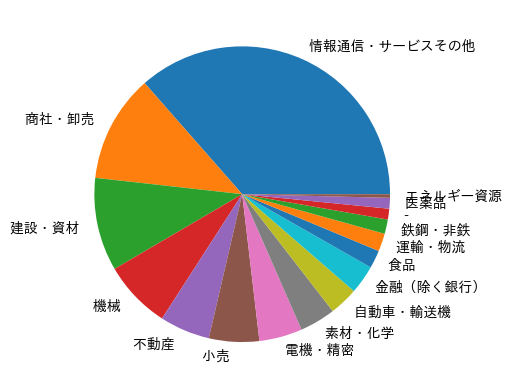

In [ ]:
# !pip install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

industrySeg33_count = df["industrySeg33"].value_counts()
industrySeg17_count = df["industrySeg17"].value_counts()

# 円グラフを表示する
# plt.pie(industrySeg33_count, labels=industrySeg33_count.index)
# plt.show()
plt.pie(industrySeg17_count, labels=industrySeg17_count.index)
plt.show()

In [ ]:
ddd = df["industrySeg17"].value_counts()


In [ ]:
import pandas as pd
df = pd.read_csv('/content/high_dividend_stock2023-05-20.csv')
df.head()

,date,symbol,name,marketSeg,industrySeg33,industrySeg17,currentPrice,per,pbr,dividendYield,dividendRate,check_roe,check_marketCap,check_payoutRatio
0,2023-05-20,1407,ウエストホールディングス,スタンダード（内国株式）,建設業,建設・資材,3085.0,33.111520,4.753423,0.0373,110.0,0.14100,125449986048,0.6174
1,2023-05-20,1719,安藤・間,プライム（内国株式）,建設業,建設・資材,1039.0,10.946060,1.160208,0.0592,60.0,0.10726,162572337152,0.4214
2,2023-05-20,1786,オリエンタル白石,プライム（内国株式）,建設業,建設・資材,315.0,9.719222,0.879348,0.0425,13.5,0.09731,36944461824,0.3363
3,2023-05-20,1808,長谷工コーポレーション,プライム（内国株式）,建設業,建設・資材,1662.0,9.337079,1.001974,0.0474,80.0,0.13611,456461680640,0.4708
4,2023-05-20,1847,イチケン,プライム（内国株式）,建設業,建設・資材,1911.0,7.999832,0.508455,0.0513,100.0,0.08159,14152407040,0.5742


In [ ]:
# 数値をパーセントに変換する
df['check_roe'] = df['check_roe'].astype(float).apply(lambda x: f'{x:.0%}' if not pd.isna(x) and x>0 else '-')

In [ ]:
df.head()

,date,symbol,name,marketSeg,industrySeg33,industrySeg17,currentPrice,per,pbr,dividendYield,dividendRate,check_roe,check_marketCap,check_payoutRatio
0,2023-05-25,1407,ウエストホールディングス,スタンダード（内国株式）,建設業,建設・資材,2763.0,32.399155,4.257280,0.0355,110.0,0.14100,117440765952,0.6174
1,2023-05-25,1429,日本アクア,プライム（内国株式）,建設業,建設・資材,916.0,17.544533,3.719918,0.0631,60.0,0.21773,28682524672,0.4600
2,2023-05-25,1719,安藤・間,プライム（内国株式）,建設業,建設・資材,1027.0,10.819638,1.143866,0.0571,60.0,0.10726,160694697984,0.4214
3,2023-05-25,1786,オリエンタル白石,プライム（内国株式）,建設業,建設・資材,305.0,9.264885,0.851432,0.0429,13.5,0.09731,35434291200,0.3363
4,2023-05-25,1808,長谷工コーポレーション,プライム（内国株式）,建設業,建設・資材,1621.0,9.105207,0.977256,0.0477,80.0,0.13611,445201186816,0.4708


## streamlit表示用の処理作成
- streamlitの使い方[参考サイト](https://data-analytics.fun/2022/01/29/understanding-streamlit-1/)

In [ ]:
!pip install streamlit==1.20.0 --quiet
!pip install pyngrok==4.1.1 --quiet
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=8518ba0da5ae83dc94f0f04aaa6526ccc755c47995b8d9c534321878b349a2fb
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [ ]:
import streamlit as st
from pyngrok import ngrok

In [ ]:
## アプリの作成
%%writefile app.py

# 以下を「app.py」に書き込み
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import plotly.graph_objs as go


st.title("日本株における高配当銘柄の一覧(予想配当3-7%)")

df = pd.read_csv('/content/high_dividend_stock2024-01-02.csv')

# カラム名を日本語に変更
df = df.rename(columns={
    "date": "日付",
    "symbol": "銘柄コード",
    "name": "銘柄名",
    "marketSeg": "市場",
    "industrySeg33": "業種1",
    "industrySeg17": "業種2",
    "currentPrice": "株価",
    "per": "PER",
    "pbr": "PBR",
    "dividendYield": "配当利率",
    "dividendRate": "1株配当",
    "check_roe": "ROE",
    "check_marketCap": "時価総額",
    "check_payoutRatio": "配当性向",
     })

## 表示変換
df['PER'] = df['PER'].astype(float).apply(lambda x: f'{x:.2f}倍' if not pd.isna(x) and x>0 else '-')
df['PBR'] = df['PBR'].astype(float).apply(lambda x: f'{x:.2f}倍' if not pd.isna(x) and x>0 else '-')
df['配当利率'] = df['配当利率'].astype(float).apply(lambda x: f'{x:.2%}' if not pd.isna(x) and x>0 else '-')
df['1株配当'] = df['1株配当'].astype(float).apply(lambda x: f'{x:.0f}円' if not pd.isna(x) and x>0 else '-')
df['ROE'] = df['ROE'].astype(float).apply(lambda x: f'{x:.2%}' if not pd.isna(x) and x>0 else '-')
df['時価総額'] = df['時価総額'].astype(float).apply(lambda x: f'{x/1e8:,.2f}億円' if not pd.isna(x) and x>0 else '-')
df['配当性向'] = df['配当性向'].astype(float).apply(lambda x: f'{x:.2%}' if not pd.isna(x) and x>0 else '-')

df = df.sort_values('配当利率', ascending=False)

# サイドバーの作成
st.sidebar.header("フィルタリング")

# フィルタ用項目を追加
marketSeg_options = df['市場'].unique().tolist()
industrySeg33_options = df['業種1'].unique().tolist()

selected_marketSeg = st.sidebar.multiselect('市場', marketSeg_options, default=marketSeg_options)
selected_industrySeg33 = st.sidebar.multiselect('業種', industrySeg33_options, default=industrySeg33_options)

# サイドバーに数字のボックスを追加
max_number = st.sidebar.number_input('表示したい株価の最大値を指定')

# 選択された情報で表をフィルタリング
filtered_df = df[(df['市場'].isin(selected_marketSeg)) & (df['業種1'].isin(selected_industrySeg33)) & (df['株価'] <= max_number)]

# 抽出されたデータの件数を大きな文字で表示
st.markdown(f"<h1 style='text-align: center; color: red; font-size: 20px;'>抽出されたデータ件数: {len(filtered_df)}</h1>", unsafe_allow_html=True)

# テーブルの表示
st.dataframe(filtered_df)



# 円グラフを作成して表示する
st.markdown("## 表示対象銘柄の業種別比率")

counts = filtered_df["業種2"].value_counts()
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts)])
st.plotly_chart(fig, use_container_width=True)

Overwriting app.py


In [ ]:
## Authtokenの設定
!ngrok authtoken 2NY3dBDUesI5aoHYVir4wmlRXUu_6dDXND7C9nWXYxWvMstXQ

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
## アプリの起動と動作確認
!streamlit run app.py &>/dev/null&  # 「&>/dev/null&」により、出力を非表示にしてバックグランドジョブとして実行

ngrok.kill()  # プロセスの修了
url = ngrok.connect(port="8501")  # 接続

INFO:pyngrok.process:ngrok process starting: 6889
2024-01-03 05:26:25.141 INFO    pyngrok.process: ngrok process starting: 6889
INFO:pyngrok.process:t=2024-01-03T05:26:25+0000 lvl=info msg="no configuration paths supplied"

2024-01-03 05:26:25.162 INFO    pyngrok.process: t=2024-01-03T05:26:25+0000 lvl=info msg="no configuration paths supplied"

INFO:pyngrok.process:t=2024-01-03T05:26:25+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

2024-01-03 05:26:25.167 INFO    pyngrok.process: t=2024-01-03T05:26:25+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

INFO:pyngrok.process:t=2024-01-03T05:26:25+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

2024-01-03 05:26:25.170 INFO    pyngrok.process: t=2024-01-03T05:26:25+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

INFO:pyngrok.process:t=2024-01-03T05:26:25+0000 lvl=info msg="starting web service" obj=

In [ ]:
print(url)

http://ba21-35-194-219-146.ngrok-free.app


In [ ]:
df.columns

Index(['date', 'symbol', 'name', 'marketSeg', 'industrySeg33', 'industrySeg17',
       'currentPrice', 'per', 'pbr', 'dividendYield', 'dividendRate',
       'check_roe', 'check_marketCap', 'check_payoutRatio'],
      dtype='object')

In [ ]:
df.query("symbol == 2124")

,date,symbol,name,marketSeg,industrySeg33,industrySeg17,currentPrice,per,pbr,dividendYield,dividendRate,check_roe,check_marketCap,check_payoutRatio
10,2023-05-27,2124,ジェイエイシーリクルートメント,プライム（内国株式）,サービス業,情報通信・サービスその他,2209.0,18.155666,7.019451,0.0694,165.0,0.39459,91358494720,0.6422


In [ ]:
df2 = df.query('symbol == 8593')

In [ ]:
df2.rename(columns={
    "date": "日付",
    "symbol": "銘柄コード",
    "name": "銘柄名",
    "marketSeg": "市場",
    "industrySeg33": "業種1",
    "industrySeg17": "業種2",
    "currentPrice": "株価",
    "per": "PER",
    "pbr": "PBR",
    "dividendYield": "配当利率",
    "dividendRate": "1株配当",
    "check_roe": "ROE",
    "check_marketCap": "時価総額",
    "check_payoutRatio": "配当性向",
     })

,日付,銘柄コード,銘柄名,市場,業種1,業種2,株価,PER,PBR,配当利率,1株配当,ROE,時価総額,配当性向
219,2023-05-20,8593,三菱ＨＣキャピタル,プライム（内国株式）,その他金融業,金融（除く銀行）,767.0,10.04979,0.71952,0.0497,38.0,0.08162,1101304561664,0.3943


In [ ]:
df

,date,symbol,name,marketSeg,industrySeg33,industrySeg17,currentPrice,per,pbr,dividendYield,dividendRate,check_roe,check_marketCap,check_payoutRatio
0,2023-05-25,1407,ウエストホールディングス,スタンダード（内国株式）,建設業,建設・資材,2763.0,32.399155,4.257280,0.0355,110.0,0.14100,117440765952,0.6174
1,2023-05-25,1429,日本アクア,プライム（内国株式）,建設業,建設・資材,916.0,17.544533,3.719918,0.0631,60.0,0.21773,28682524672,0.4600
2,2023-05-25,1719,安藤・間,プライム（内国株式）,建設業,建設・資材,1027.0,10.819638,1.143866,0.0571,60.0,0.10726,160694697984,0.4214
3,2023-05-25,1786,オリエンタル白石,プライム（内国株式）,建設業,建設・資材,305.0,9.264885,0.851432,0.0429,13.5,0.09731,35434291200,0.3363
4,2023-05-25,1808,長谷工コーポレーション,プライム（内国株式）,建設業,建設・資材,1621.0,9.105207,0.977256,0.0477,80.0,0.13611,445201186816,0.4708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2023-05-25,9889,ＪＢＣＣホールディングス,プライム（内国株式）,情報・通信業,情報通信・サービスその他,2258.0,13.608969,1.788236,0.0365,80.0,0.14139,35423956992,0.3787
251,2023-05-25,9908,日本電計,スタンダード（内国株式）,卸売業,商社・卸売,1810.0,8.719110,0.830828,0.0490,90.0,0.11525,21191841792,0.3332
252,2023-05-25,9928,ミロク情報サービス,プライム（内国株式）,情報・通信業,情報通信・サービスその他,1488.0,12.028131,1.830080,0.0591,90.0,0.15995,44663660544,0.3218
253,2023-05-25,9934,因幡電機産業,プライム（内国株式）,卸売業,商社・卸売,3055.0,11.964439,1.120716,0.0385,120.0,0.10549,169081716736,0.3885


In [ ]:
df['check_roe'] = df['check_roe'].astype(float).apply(lambda x: f'{x:.0%}' if not pd.isna(x) and x>0 else '-')
df

,date,symbol,name,marketSeg,industrySeg33,industrySeg17,currentPrice,per,pbr,dividendYield,dividendRate,check_roe,check_marketCap,check_payoutRatio
0,2023-05-25,1407,ウエストホールディングス,スタンダード（内国株式）,建設業,建設・資材,2763.0,32.399155,4.257280,0.0355,110.0,14%,117440765952,0.6174
1,2023-05-25,1429,日本アクア,プライム（内国株式）,建設業,建設・資材,916.0,17.544533,3.719918,0.0631,60.0,22%,28682524672,0.4600
2,2023-05-25,1719,安藤・間,プライム（内国株式）,建設業,建設・資材,1027.0,10.819638,1.143866,0.0571,60.0,11%,160694697984,0.4214
3,2023-05-25,1786,オリエンタル白石,プライム（内国株式）,建設業,建設・資材,305.0,9.264885,0.851432,0.0429,13.5,10%,35434291200,0.3363
4,2023-05-25,1808,長谷工コーポレーション,プライム（内国株式）,建設業,建設・資材,1621.0,9.105207,0.977256,0.0477,80.0,14%,445201186816,0.4708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2023-05-25,9889,ＪＢＣＣホールディングス,プライム（内国株式）,情報・通信業,情報通信・サービスその他,2258.0,13.608969,1.788236,0.0365,80.0,14%,35423956992,0.3787
251,2023-05-25,9908,日本電計,スタンダード（内国株式）,卸売業,商社・卸売,1810.0,8.719110,0.830828,0.0490,90.0,12%,21191841792,0.3332
252,2023-05-25,9928,ミロク情報サービス,プライム（内国株式）,情報・通信業,情報通信・サービスその他,1488.0,12.028131,1.830080,0.0591,90.0,16%,44663660544,0.3218
253,2023-05-25,9934,因幡電機産業,プライム（内国株式）,卸売業,商社・卸売,3055.0,11.964439,1.120716,0.0385,120.0,11%,169081716736,0.3885


In [ ]:
df = pd.read_csv('/content/high_dividend_stock2023-06-10.csv')

# カラム名を日本語に変更
df = df.rename(columns={
    "date": "日付",
    "symbol": "銘柄コード",
    "name": "銘柄名",
    "marketSeg": "市場",
    "industrySeg33": "業種1",
    "industrySeg17": "業種2",
    "currentPrice": "株価",
    "per": "PER",
    "pbr": "PBR",
    "dividendYield": "配当利率",
    "dividendRate": "1株配当",
    "check_roe": "ROE",
    "check_marketCap": "時価総額",
    "check_payoutRatio": "配当性向",
     })

## 表示変換
df['PER'] = df['PER'].astype(float).apply(lambda x: f'{x:.2f}倍' if not pd.isna(x) and x>0 else '-')
df['PBR'] = df['PBR'].astype(float).apply(lambda x: f'{x:.2f}倍' if not pd.isna(x) and x>0 else '-')
df['配当利率'] = df['配当利率'].astype(float).apply(lambda x: f'{x:.2%}' if not pd.isna(x) and x>0 else '-')
df['1株配当'] = df['1株配当'].astype(float).apply(lambda x: f'{x:.0f}円' if not pd.isna(x) and x>0 else '-')
df['ROE'] = df['ROE'].astype(float).apply(lambda x: f'{x:.2%}' if not pd.isna(x) and x>0 else '-')
df['時価総額'] = df['時価総額'].astype(float).apply(lambda x: f'{x/1e8:,.2f}億円' if not pd.isna(x) and x>0 else '-')
df['配当性向'] = df['配当性向'].astype(float).apply(lambda x: f'{x:.2%}' if not pd.isna(x) and x>0 else '-')

df = df.sort_values('配当利率', ascending=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 74 to 78
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日付      120 non-null    object 
 1   銘柄コード   120 non-null    int64  
 2   銘柄名     120 non-null    object 
 3   市場      120 non-null    object 
 4   業種1     120 non-null    object 
 5   業種2     120 non-null    object 
 6   株価      120 non-null    float64
 7   PER     120 non-null    object 
 8   PBR     120 non-null    object 
 9   配当利率    120 non-null    object 
 10  1株配当    120 non-null    object 
 11  ROE     120 non-null    object 
 12  時価総額    120 non-null    object 
 13  配当性向    120 non-null    object 
dtypes: float64(1), int64(1), object(12)
memory usage: 14.1+ KB


## 高配当株抽出アプリの一括稼動処理

In [ ]:
!pip install streamlit==1.20.0 --quiet
!pip install pyngrok==4.1.1 --quiet
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 33.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=bcef6bbc376dfd5d24dac70f2f341d75e84ac6fdbc33537be56da3cb231a96c7
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [ ]:
import requests
import pandas as pd
import yfinance as yf
from datetime import datetime, date, timedelta
import time
import streamlit as st
from pyngrok import ngrok

## 銘柄コードの取得
url = 'https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls' # ファイルのURLを指定する
filename = 'data_j.xlsx' # 保存するファイル名を指定する
response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)

# 取得したXLSXファイルを読み込み、DataFrameに変換
bond_master = pd.read_excel('data_j.xlsx')

## 銘柄コードを取得
codes = bond_master["コード"]

# 本日を取得
today = datetime.today()

# 前日を取得（形式を'%Y-%m-%d'に変更）する
date = (today - timedelta(days=1)).strftime('%Y-%m-%d')

# 銘柄を抽出する際の条件
dividendYield_donw_limit = 0.03     # 配当利回り下限(3%未満は旨みが少ない)
dividendYield_upper_limit = 0.07    # 配当利回り上限(7%以上だと、罠銘柄の可能性がある)
payoutratio = 0.3                  # 配当性向（50%以下が望ましい:利益から投資家へ払う割合）
marketcap = 50000000000       # 時価総額(企業の大きさ)
roe = 0.08                         # 自己資本利益率

# 空のリストを作成
bond_list = []

# 銘柄コードから株の必要情報を抽出して、dataframeにappendしていく
for code in codes:
  # 銘柄名の設定
  ticker = f"{code}.T"

  # yfinanceを使用して株価情報を取得
  data = yf.Ticker(ticker)

  # ROEが入ってない場合がある為、存在有無を確認
  if 'returnOnEquity' in data.info:
    check_roe = data.info["returnOnEquity"] # ROE
  else:
    check_roe = 0 ## 存在しない場合は0を設定

  # 予想配当が入ってない場合がある為、存在有無を確認
  if 'dividendYield' in data.info:
    check_dividendYield = data.info["dividendYield"] # 予想配当
  else:
    check_dividendYield = 0 ## 存在しない場合は0を設定

  # 時価総額が入ってない場合がある為、存在有無を確認
  if 'marketCap' in data.info:
    check_marketCap = data.info["marketCap"] # 時価総額
  else:
    check_marketCap = 0 ## 存在しない場合は0を設定

  # 自己資本比率が入ってない場合がある為、存在有無を確認
  # if 'capitalAdequacyRatio' in data.info:
  #   check_capitalAdequacyRatio = data.info["capitalAdequacyRatio"] # 自己資本比率
  # else:
  #   check_capitalAdequacyRatio = 0 ## 存在しない場合は0を設定

  # 配当性向が入ってない場合がある為、存在有無を確認
  if 'payoutRatio' in data.info:
    check_payoutRatio = data.info["payoutRatio"] # 自己資本比率
  else:
    check_payoutRatio = 0 ## 存在しない場合は0を設定


  ## roeが指定値(8%)以上の銘柄のみ取得
  if(check_roe >= roe):

    ## 配当が3%以上、7%未満の銘柄のみ抽出
    if dividendYield_donw_limit <= check_dividendYield < dividendYield_upper_limit:

      ## 時価総額が5000億円以上
       if check_marketCap >= marketcap:

        # # 自己資本比率がしきい値を満たしているかを判定する
        # if check_capitalAdequacyRatio >= capitalAdequacyRatio:

        # 配当性向がしきい値を満たしているかを判定する
        if check_payoutRatio >= payoutratio:

          # 必要指標を取得(JPX日本上場企業情報サービスのデータより)
          selected_row = bond_master[bond_master["コード"] == code].iloc[0]
          symbol = selected_row["コード"]
          name = selected_row["銘柄名"]
          marketSeg = selected_row["市場・商品区分"]
          industrySeg33 = selected_row["33業種区分"]
          industrySeg17 = selected_row["17業種区分"]

          # 必要指標を取得(yfinanceの銘柄情報)
          currentPrice = data.info["currentPrice"] # 直近終値

          # PERが入ってない場合がある為、存在有無を確認
          if 'trailingPE' in data.info:
            per = data.info["trailingPE"] # PER
          else:
            per = 'none' ## 存在しない場合は 'none' を設定
          pbr = data.info["priceToBook"] # PBR
          dividendYield  = data.info["dividendYield"] # 配当率
          dividendRate  = data.info["dividendRate"]# 1株配当

          # リストに追加
          bond_list.append((
              date,
              symbol,
              name,
              marketSeg,
              industrySeg33,
              industrySeg17,
              currentPrice,
              per,
              pbr,
              dividendYield,
              dividendRate,
              check_roe,
              # check_dividendYield,
              check_marketCap,
              # check_capitalAdequacyRatio,
              check_payoutRatio
              ))

# リストからDataFrameを作成
df = pd.DataFrame(
    bond_list,
    columns=[
        'date',
        'symbol',
        'name',
        'marketSeg',
        'industrySeg33',
        'industrySeg17',
        'currentPrice',
        'per',
        'pbr',
        'dividendYield',
        'dividendRate',
        'check_roe',
        # 'check_dividendYield',
        'check_marketCap',
        # 'check_capitalAdequacyRatio',
        'check_payoutRatio',
    ]
)

# 対象銘柄情報を配当率順に並び替えて表示
df.sort_values('dividendYield', ascending=False)

# CSVファイルに出力()ファイル名に日付を設定
df.to_csv(f'high_dividend_stock{date}.csv', index=False, encoding='utf-8')

In [ ]:
## アプリの作成
%%writefile app.py

# 以下を「app.py」に書き込み
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import plotly.graph_objs as go
from datetime import datetime, date, timedelta

# 本日を取得
today = datetime.today()

# 前日を取得（形式を'%Y-%m-%d'に変更）する
date = (today - timedelta(days=1)).strftime('%Y-%m-%d')


st.title("日本株における高配当銘柄の一覧(予想配当3-7%)")

df = pd.read_csv(f'/content/high_dividend_stock{date}.csv')

# カラム名を日本語に変更
df = df.rename(columns={
    "date": "日付",
    "symbol": "銘柄コード",
    "name": "銘柄名",
    "marketSeg": "市場",
    "industrySeg33": "業種1",
    "industrySeg17": "業種2",
    "currentPrice": "株価",
    "per": "PER",
    "pbr": "PBR",
    "dividendYield": "配当利率",
    "dividendRate": "1株配当",
    "check_roe": "ROE",
    "check_marketCap": "時価総額",
    "check_payoutRatio": "配当性向",
     })

## 表示変換
df['PER'] = df['PER'].astype(float).apply(lambda x: f'{x:.2f}倍' if not pd.isna(x) and x>0 else '-')
df['PBR'] = df['PBR'].astype(float).apply(lambda x: f'{x:.2f}倍' if not pd.isna(x) and x>0 else '-')
df['配当利率'] = df['配当利率'].astype(float).apply(lambda x: f'{x:.2%}' if not pd.isna(x) and x>0 else '-')
df['1株配当'] = df['1株配当'].astype(float).apply(lambda x: f'{x:.0f}円' if not pd.isna(x) and x>0 else '-')
df['ROE'] = df['ROE'].astype(float).apply(lambda x: f'{x:.2%}' if not pd.isna(x) and x>0 else '-')
df['時価総額'] = df['時価総額'].astype(float).apply(lambda x: f'{x/1e8:,.2f}億円' if not pd.isna(x) and x>0 else '-')
df['配当性向'] = df['配当性向'].astype(float).apply(lambda x: f'{x:.2%}' if not pd.isna(x) and x>0 else '-')

df = df.sort_values('配当利率', ascending=False)

# サイドバーの作成
st.sidebar.header("フィルタリング")

# フィルタ用項目を追加
marketSeg_options = df['市場'].unique().tolist()
industrySeg33_options = df['業種1'].unique().tolist()

selected_marketSeg = st.sidebar.multiselect('市場', marketSeg_options, default=marketSeg_options)
selected_industrySeg33 = st.sidebar.multiselect('業種', industrySeg33_options, default=industrySeg33_options)

# サイドバーに数字のボックスを追加
max_number = st.sidebar.number_input('表示したい株価の最大値を指定')

# 選択された情報で表をフィルタリング
filtered_df = df[(df['市場'].isin(selected_marketSeg)) & (df['業種1'].isin(selected_industrySeg33)) & (df['株価'] <= max_number)]

# 抽出されたデータの件数を大きな文字で表示
st.markdown(f"<h1 style='text-align: center; color: red; font-size: 20px;'>抽出されたデータ件数: {len(filtered_df)}</h1>", unsafe_allow_html=True)

# テーブルの表示
st.dataframe(filtered_df)



# 円グラフを作成して表示する
st.markdown("## 表示対象銘柄の業種別比率")

counts = filtered_df["業種2"].value_counts()
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts)])
st.plotly_chart(fig, use_container_width=True)

Writing app.py


In [ ]:
## Authtokenの設定
!ngrok authtoken 2NY3dBDUesI5aoHYVir4wmlRXUu_6dDXND7C9nWXYxWvMstXQ

## アプリの起動と動作確認
!streamlit run app.py &>/dev/null&  # 「&>/dev/null&」により、出力を非表示にしてバックグランドジョブとして実行

ngrok.kill()  # プロセスの修了
url = ngrok.connect(port="8501")  # 接続

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


INFO:pyngrok.process:ngrok process starting: 6331
2023-10-25 10:35:23.989 INFO    pyngrok.process: ngrok process starting: 6331
INFO:pyngrok.process:t=2023-10-25T10:35:24+0000 lvl=info msg="no configuration paths supplied"

2023-10-25 10:35:24.049 INFO    pyngrok.process: t=2023-10-25T10:35:24+0000 lvl=info msg="no configuration paths supplied"

INFO:pyngrok.process:t=2023-10-25T10:35:24+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

2023-10-25 10:35:24.056 INFO    pyngrok.process: t=2023-10-25T10:35:24+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

INFO:pyngrok.process:t=2023-10-25T10:35:24+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

2023-10-25 10:35:24.062 INFO    pyngrok.process: t=2023-10-25T10:35:24+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

INFO:pyngrok.process:t=2023-10-25T10:35:24+0000 lvl=info msg="starting web service" obj=

In [ ]:
print(url)

http://153a-35-237-181-110.ngrok-free.app


In [ ]:
df = pd.read_csv(f'/content/high_dividend_stock{date}.csv')

# カラム名を日本語に変更
df = df.rename(columns={
    "date": "日付",
    "name": "銘柄名",
    "currentPrice": "現在価格",
     })
df[["日付","銘柄名","現在価格"]]

,日付,銘柄名,現在価格
0,2023-08-12,ウエストホールディングス,2583.0
1,2023-08-12,安藤・間,1156.0
2,2023-08-12,長谷工コーポレーション,1783.5
3,2023-08-12,淺沼組,3430.0
4,2023-08-12,大東建託,15675.0
...,...,...,...
107,2023-08-12,ＮＳＤ,2721.0
108,2023-08-12,ベネッセホールディングス,1853.0
109,2023-08-12,福井コンピュータホールディングス,2644.0
110,2023-08-12,因幡電機産業,3080.0


## vscodeの拡張機能: 25個

-  .NET Install Tool for Extension Authors
- C#
- Dev Containers
- Docker
- ESLint
- Excel Viewer
- indent-rainbow
- IntelliCode
- IntelliCode API Usage Examples
- isort
- Japanese Language Pack for Visual Stud
- Jupyter
- Jupyter Cell Tags
- Jupyter Keymap
- Jupyter Notebook Renderers
- Jupyter Slide Show
- Live Share
- Path Intellisense
- Prettier - Code formatter
- Pylance
- Python
- SQL (BigQuery)
- SQL Formatter
- vscode-icons
- zenkaku


In [3]:
!pip install yahooquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00
